# Artur Kompała

Celem zadania jest stworzenie modelu do prognozowania przyszłych cen akcji na podstawie historycznych danych giełdowych z użyciem sieci rekurencyjnej (RNN lub LSTM).

dane do wykrozystania:

https://www.kaggle.com/datasets/jacksoncrow/stock-market-dataset

C:\Users\megaz\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.13_qbz5n2kfra8p0\LocalCache\local-packages\Python313\site-packages\keras\src\layers\rnn\rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Rozpoczynam trening modelu...
Epoch 1/50
132/132 ━━━━━━━━━━━━━━━━━━━━ 21s 128ms/step - loss: 8.8961e-05 - val_loss: 0.0014
Epoch 2/50
132/132 ━━━━━━━━━━━━━━━━━━━━ 16s 119ms/step - loss: 2.2748e-05 - val_loss: 0.0018
Epoch 3/50
132/132 ━━━━━━━━━━━━━━━━━━━━ 15s 115ms/step - loss: 2.1200e-05 - val_loss: 0.0026
Epoch 4/50
132/132 ━━━━━━━━━━━━━━━━━━━━ 15s 114ms/step - loss: 1.7861e-05 - val_loss: 0.0010
Epoch 5/50
132/132 ━━━━━━━━━━━━━━━━━━━━ 15s 113ms/step - loss: 1.7307e-05 - val_loss: 0.0012
Epoch 6/50
132/132 ━━━━━━━━━━━━━━━━━━━━ 16s 121ms/step - loss: 1.5542e-05 - val_loss: 0.0051
Epoch 7/50
132/132 ━━━━━━━━━━━━━━━━━━━━ 16s 118ms/step - loss: 1.4818e-05 - val_loss: 0.0014
Epoch 8/50
132/132 ━━━━━━━━━━━━━━━━━━━━ 16s 119ms/step - loss: 1.4888e-05 - val_loss: 0.0014
Epoch 9/50
132/132 ━━━━━━━━━━━━━━━━━━━━ 15s 111ms/step - loss: 1.4198e-05 - val_loss: 8.6756e-04
Epoch 10/50
132/132 ━━━━━━━━━━━━━━━━━━━━ 15s 113ms/step - loss: 1.2611e-05 - val_loss: 0.0010
Epoch 11/50
132/132 ━━━━━━━━━━━━━━━

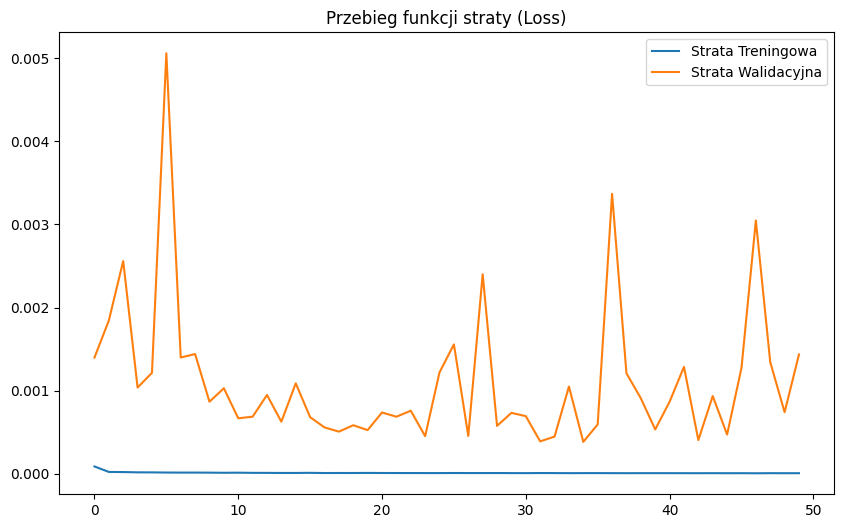

34/34 ━━━━━━━━━━━━━━━━━━━━ 2s 54ms/step
Średni błąd bezwzględny (MAE): 9.156473485434928
Średni błąd kwadratowy (MSE): 141.0747844737988
Pierwiastek ze średniego błędu kwadratowego (RMSE): 11.877490664016486


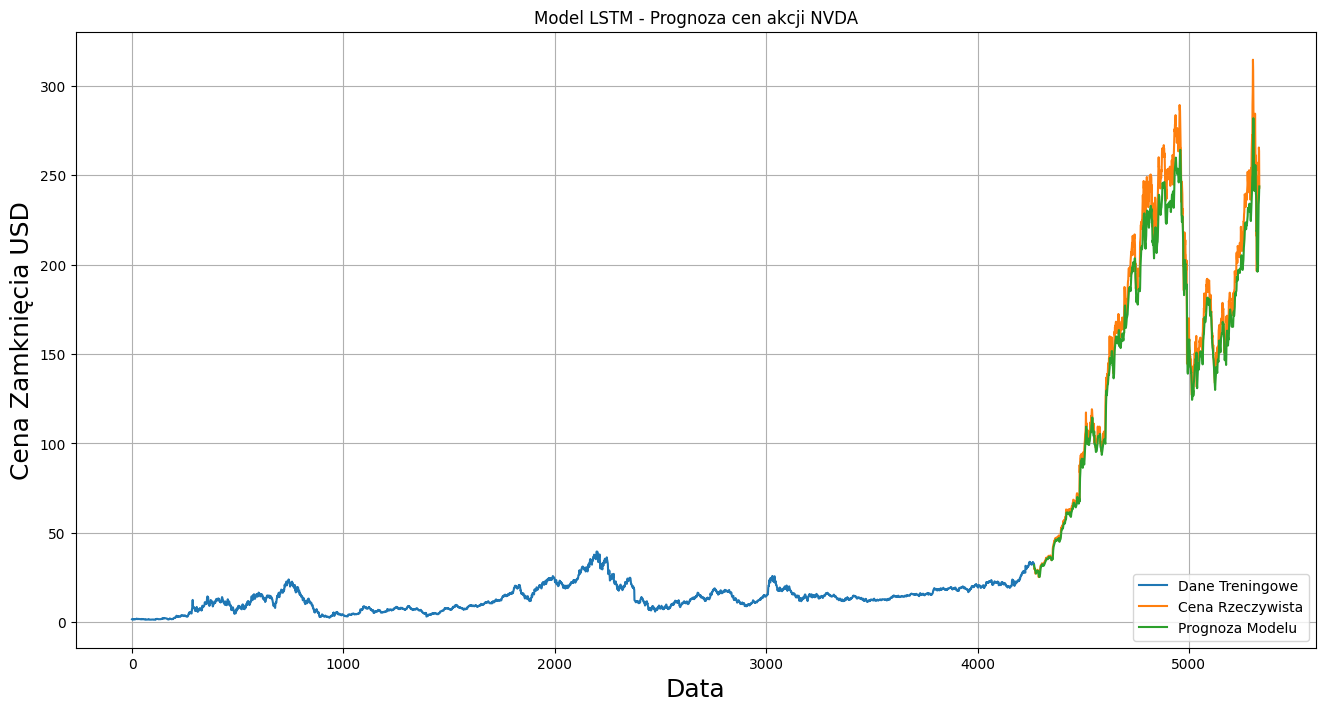

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_absolute_error, mean_squared_error
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM, Dropout

# 1. Wczytanie danych z pliku
df = pd.read_csv('data/NVDA.csv')

# 2. Czyszczenie i przygotowanie danych
df['Date'] = pd.to_datetime(df['Date'], errors='coerce')
df = df.sort_values('Date')
df['Close'] = pd.to_numeric(df['Close'], errors='coerce')
df = df.dropna(subset=['Date', 'Close'])

data = df.filter(['Close'])
dataset = data.values

# 3. Normalizacja danych
scaler = MinMaxScaler(feature_range=(0, 1))
scaled_data = scaler.fit_transform(dataset)

prediction_days = 60
training_data_len = int(np.ceil(len(dataset) * 0.8))

# Przygotowanie zbioru treningowego
train_data = scaled_data[0:training_data_len, :]
x_train = []
y_train = []

for i in range(prediction_days, len(train_data)):
    x_train.append(train_data[i-prediction_days:i, 0])
    y_train.append(train_data[i, 0])

x_train, y_train = np.array(x_train), np.array(y_train)
x_train = np.reshape(x_train, (x_train.shape[0], x_train.shape[1], 1))

# Przygotowanie zbioru testowego
test_data = scaled_data[training_data_len - prediction_days:, :]
x_test = []
y_test_original = dataset[training_data_len:, :] # Oryginalne wartości do porównania

for i in range(prediction_days, len(test_data)):
    x_test.append(test_data[i-prediction_days:i, 0])

x_test = np.array(x_test)
x_test = np.reshape(x_test, (x_test.shape[0], x_test.shape[1], 1))
# Przygotowanie y_test w skali znormalizowanej do walidacji podczas treningu
y_test_scaled = scaled_data[training_data_len:, 0]

# 4. Budowa modelu LSTM
model = Sequential()

# Pierwsza warstwa LSTM + Dropout
model.add(LSTM(150, return_sequences=True, input_shape=(x_train.shape[1], 1)))
model.add(Dropout(0.2))

# Druga warstwa LSTM + Dropout
model.add(LSTM(150, return_sequences=True))
model.add(Dropout(0.2))

# Trzecia warstwa LSTM + Dropout
model.add(LSTM(150, return_sequences=False))
model.add(Dropout(0.2))

# Warstwa wyjściowa
model.add(Dense(1))

# Kompilacja modelu
model.compile(optimizer='adam', loss='mean_squared_error')

# Trenowanie modelu
print("Rozpoczynam trening modelu...")
history = model.fit(
    x_train,
    y_train,
    batch_size=32,
    epochs=50,
    validation_data=(x_test, y_test_scaled)
)

# Wykres straty
plt.figure(figsize=(10, 6))
plt.plot(history.history['loss'], label='Strata Treningowa')
plt.plot(history.history['val_loss'], label='Strata Walidacyjna')
plt.title('Przebieg funkcji straty (Loss)')
plt.legend()
plt.show()

# 5. Predykcja
predictions = model.predict(x_test)
predictions = scaler.inverse_transform(predictions)

# 6. Obliczanie metryk błędów
mae = mean_absolute_error(y_test_original, predictions)
mse = mean_squared_error(y_test_original, predictions)
rmse = np.sqrt(mse)

print(f'Średni błąd bezwzględny (MAE): {mae}')
print(f'Średni błąd kwadratowy (MSE): {mse}')
print(f'Pierwiastek ze średniego błędu kwadratowego (RMSE): {rmse}')

# 7. Wizualizacja wyników
train = data[:training_data_len]
valid = data[training_data_len:].copy()
valid.loc[:, 'Predictions'] = predictions

plt.figure(figsize=(16, 8))
plt.title('Model LSTM - Prognoza cen akcji NVDA')
plt.xlabel('Data', fontsize=18)
plt.ylabel('Cena Zamknięcia USD', fontsize=18)
plt.plot(train['Close'], label='Dane Treningowe')
plt.plot(valid['Close'], label='Cena Rzeczywista')
plt.plot(valid['Predictions'], label='Prognoza Modelu')
plt.legend(loc='lower right')
plt.grid(True)
plt.show()